# Synthetic Brand Generation with GANs

## Project Goal
Generate synthetic brand data to address class imbalance in hierarchical clustering using:
- **CTGAN**: For generating realistic brand features (ESG metrics, demographics, business characteristics)
- **DistilGPT2**: For generating realistic brand names

## Dataset
- **Source**: `data/raw/brand_information.csv`
- **Size**: 3,605 brands with 80+ features
- **Problem**: Hierarchical clustering produces only 2 clusters (severe imbalance)

## Notebook Structure
1. **Phase 1**: Data Preparation & Exploration
2. **Phase 2**: CTGAN Training (Tabular Features)
3. **Phase 3**: Brand Name Generation (DistilGPT2)
4. **Phase 4**: Synthetic Data Generation
5. **Phase 5**: Evaluation & Clustering Comparison

## Setup & Installation

In [ ]:
!git clone https://github.com/dyegofern/csca5642-deep-learning.git
#!pip install -q sdv transformers torch pandas numpy scikit-learn matplotlib seaborn plotly scipy

# Import libraries
import sys
import os
from google.colab import drive

MAPPED_DIR = '/content/csca5642-deep-learning'

# Mount Google Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

DATA_PATH = MAPPED_DIR + '/data/raw/brand_information.csv'

# Set output and model directories to Google Drive
DRIVE_OUTPUT_BASE = '/content/drive/MyDrive/Colab_Output/SyntheticBrandGeneration'
OUTPUT_DIR = os.path.join(DRIVE_OUTPUT_BASE, 'outputs')
MODEL_DIR = os.path.join(DRIVE_OUTPUT_BASE, 'models')

# Add src to path (for local imports)
src_path = MAPPED_DIR + '/src'
if src_path not in sys.path:
    sys.path.append(src_path)

# Add data to path (for local imports) - as specified by the user
data_path = MAPPED_DIR + '/data'
if data_path not in sys.path:
    sys.path.append(data_path)

fatal: destination path 'csca5642-deep-learning' already exists and is not an empty directory.


In [ ]:
# Import our custom modules
from data_processor import BrandDataProcessor
from tabular_gan import TabularBrandGAN
from brand_name_generator import BrandNameGenerator
from evaluator import BrandDataEvaluator

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(" All modules loaded successfully!")

✓ All modules loaded successfully!


## Configuration

In [27]:
# Paths (adjust for Colab if needed)
DATA_PATH = data_path + '/raw/brand_information.csv'
OUTPUT_DIR = '../data/generated/'
MODEL_DIR = '../models/'

# Create directories
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

# Training parameters
CTGAN_EPOCHS = 300
CTGAN_BATCH_SIZE = 500
GPT2_EPOCHS = 3
GPT2_BATCH_SIZE = 8

# Generation parameters
N_SYNTHETIC_BRANDS = 500  # Total synthetic brands to generate
MIN_BRANDS_PER_COMPANY = 3  # Minimum brands a company should have

print(f"Data path: {DATA_PATH}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Model directory: {MODEL_DIR}")

Data path: /content/csca5642-deep-learning/data/raw/brand_information.csv
Output directory: ../data/generated/
Model directory: ../models/


In [20]:
#from google.colab import drive
#drive.mount('/content/drive')

---
# Phase 1: Data Preparation & Exploration

Load and explore the brand dataset, then prepare it for GAN training.

## 1.1 Load Data

In [28]:
# Initialize data processor
processor = BrandDataProcessor(DATA_PATH)

# Load data
df = processor.load_data()
df.head()

Loading data from /content/csca5642-deep-learning/data/raw/brand_information.csv...
Loaded 3605 brands with 77 features


,industry_id,industry_name,deforestation_risk,labor_exploitation_risk,chemical_pollution_risk,supply_chain_greenwashing_risk,positive_innovation_risk,esg_summary,company_id,company_name,...,supply_chain_localization,product_portfolio_diversity,revenue_billion_usd,customer_loyalty_index,r_and_d_spend_percent_revenue,women_board_percent,ceo_tenure_years,market_cap_billion_usd,major_sustainability_award_last5y,references_and_links
0,10,Household & Personal Products,1,1,1,0,0,Household & Personal Products industry demonst...,125,"S. C. Johnson & Son, Inc.",...,85,2,0.04,55,0.5,20,3,0.0,0,https://www.galaxus.ch; Limited English sources
1,6,Processed Foods,1,1,1,0,0,Processed foods industry demonstrates ESG para...,51,Ferrero Group,...,40,1,0.18,65,0.8,25,2,0.0,0,https://en.wikipedia.org/wiki/100_Grand_Bar
2,17,"Meat, Poultry & Dairy",1,1,1,0,0,"Meat, Poultry & Dairy industry faces severe ES...",96,Foremost Farms USA Cooperative,...,90,1,0.02,70,0.1,15,4,0.0,0,https://www.foremostfarms.com/foremost-farms-a...
3,6,Processed Foods,1,1,1,0,0,Processed foods industry demonstrates ESG para...,95,"Wells Enterprises, Inc.",...,70,2,0.03,72,0.5,20,3,0.0,0,http://www.onsecondscoop.com/2014/04/2nd-st-cr...
4,6,Processed Foods,1,1,1,0,0,Processed foods industry demonstrates ESG para...,10,"Mars, Incorporated",...,45,1,0.25,72,0.8,25,3,0.0,0,https://www.businessinsider.com/mars-inc-famil...


## 1.2 Exploratory Data Analysis


=== Data Exploration ===
Total brands: 3605
Total features: 77

Top 10 companies by brand count:
  Nestle: 126 brands
  Bayer: 95 brands
  Conagra Brands Inc.: 94 brands
  Hershey Company: 79 brands
  General Mills: 75 brands
  JBS USA: 74 brands
  PepsiCo, Inc.: 69 brands
  Ferrero Group: 69 brands
  Ajinomoto: 62 brands
  Target: 58 brands


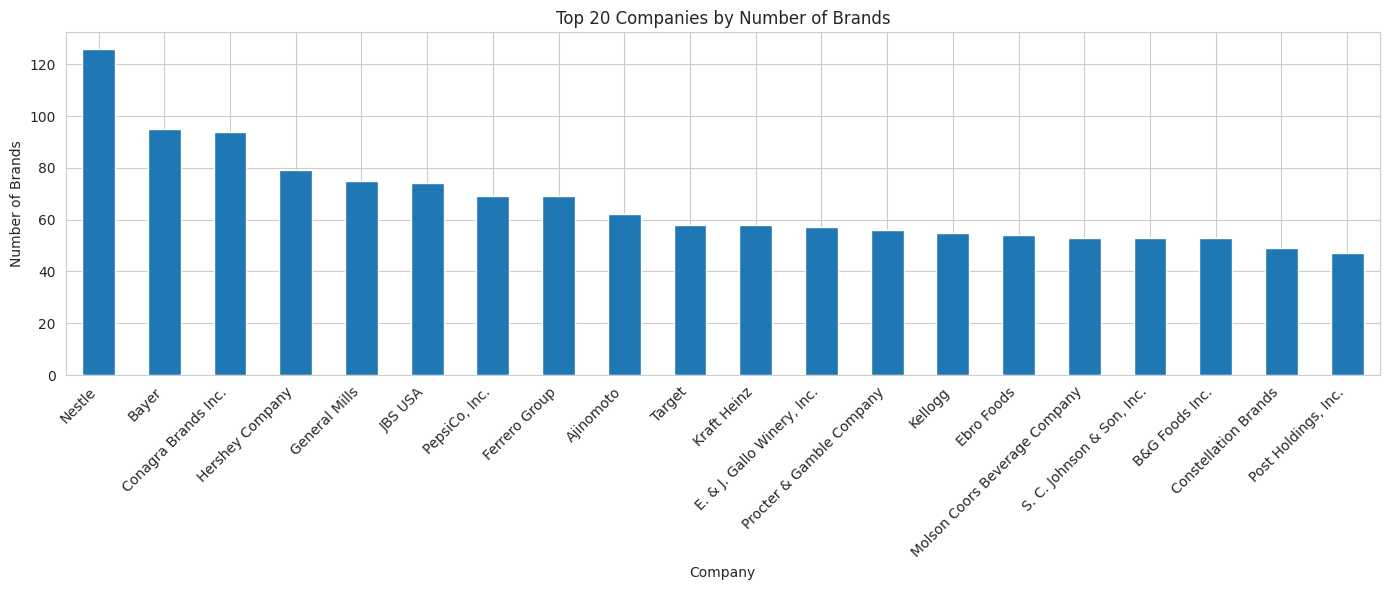


Companies with 1 brand: 40
Companies with 2+ brands: 203
Companies with 5+ brands: 153


In [29]:
# Explore the dataset
stats = processor.explore_data()

# Visualize brands per company
brand_counts = pd.Series(stats['brands_per_company'])
top_companies = brand_counts.head(20)

plt.figure(figsize=(14, 6))
top_companies.plot(kind='bar')
plt.title('Top 20 Companies by Number of Brands')
plt.xlabel('Company')
plt.ylabel('Number of Brands')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"\nCompanies with 1 brand: {(brand_counts == 1).sum()}")
print(f"Companies with 2+ brands: {(brand_counts >= 2).sum()}")
print(f"Companies with 5+ brands: {(brand_counts >= 5).sum()}")

In [30]:
# Identify multi-brand companies (good for training)
multi_brand_companies = processor.get_multi_brand_companies(min_brands=3)

print(f"\nIdentified {len(multi_brand_companies)} companies with 3+ brands")
print("\nExample companies:")
for company in multi_brand_companies[:10]:
    n_brands = len(processor.get_company_brands(company))
    print(f"  {company}: {n_brands} brands")


Found 186 companies with 3+ brands

Identified 186 companies with 3+ brands

Example companies:
  Nestle: 126 brands
  Bayer: 95 brands
  Conagra Brands Inc.: 94 brands
  Hershey Company: 79 brands
  General Mills: 75 brands
  JBS USA: 74 brands
  PepsiCo, Inc.: 69 brands
  Ferrero Group: 69 brands
  Ajinomoto: 62 brands
  Target: 58 brands


## 1.3 Data Cleaning & Preprocessing

In [31]:
# Clean the data
df_clean = processor.clean_data(drop_text_heavy=True)

# Check for missing values
missing = df_clean.isnull().sum()
print(f"\nRemaining missing values: {missing[missing > 0]}")


=== Data Cleaning ===

Identified 54 numerical features
Identified 7 categorical features
Identified 6 text features (will be handled separately)
Dropped text-heavy columns: ['esg_summary', 'accusation', 'references_and_links']

Handling missing values...
  Filled demographics_gender with mode/Unknown
  Filled demographics_lifestyle with mode/Unknown

Cleaned dataset: 3605 rows, 74 columns

Remaining missing values: fossil_fuel_reliance      146
esg_programs              146
sustainability_actions    146
target_population         146
main_partnerships         146
dtype: int64


In [32]:
# Prepare data for GAN training
train_df, val_df = processor.prepare_for_gan(test_size=0.2)

print(f"\nTraining set shape: {train_df.shape}")
print(f"Validation set shape: {val_df.shape}")
print(f"\nFeatures for GAN: {list(train_df.columns)}")


=== Preparing Data for GAN ===

Encoding categorical features...
  Encoded industry_name: 14 unique values
  Encoded country_of_origin: 42 unique values
  Encoded headquarters_country: 43 unique values
  Encoded demographics_income_level: 84 unique values
  Encoded demographics_geographic_reach: 167 unique values
  Encoded demographics_gender: 49 unique values
  Encoded demographics_lifestyle: 3540 unique values
  Encoded company_name: 243 companies
Added 40 single-brand companies to training set.

Train set: 2892 brands
Validation set: 713 brands

Training set shape: (2892, 62)
Validation set shape: (713, 62)

Features for GAN: ['company_name', 'industry_name', 'country_of_origin', 'headquarters_country', 'demographics_income_level', 'demographics_geographic_reach', 'demographics_gender', 'demographics_lifestyle', 'deforestation_risk', 'labor_exploitation_risk', 'chemical_pollution_risk', 'supply_chain_greenwashing_risk', 'positive_innovation_risk', 'scope_v_revenues', 'reported_scop

---
# Phase 2: CTGAN Training (Tabular Features)

Train CTGAN to generate realistic brand features conditioned on company name.

## 2.1 Initialize and Train CTGAN

In [33]:
# Initialize CTGAN
ctgan = TabularBrandGAN(
    epochs=CTGAN_EPOCHS,
    batch_size=CTGAN_BATCH_SIZE,
    verbose=True
)

# Identify discrete columns (categorical features that were encoded)
discrete_cols = processor.categorical_features + ['company_name']
discrete_cols = [col for col in discrete_cols if col in train_df.columns]

print(f"Discrete columns for CTGAN: {discrete_cols}")

Discrete columns for CTGAN: ['industry_name', 'country_of_origin', 'headquarters_country', 'demographics_income_level', 'demographics_geographic_reach', 'demographics_gender', 'demographics_lifestyle', 'company_name']


In [34]:
# Train CTGAN (this may take 10-30 minutes depending on GPU)
ctgan.train(train_df, discrete_columns=discrete_cols)


=== Training CTGAN ===
Training on 2892 samples with 62 features
Training for 300 epochs with batch size 500...


Gen. (-4.05) | Discrim. (-0.67): 100%|██████████| 300/300 [01:43<00:00,  2.90it/s]

Training completed!


In [35]:
# Save the trained model
ctgan_model_path = os.path.join(MODEL_DIR, 'ctgan_brand_model.pkl')
ctgan.save_model(ctgan_model_path)

Model saved to ../models/ctgan_brand_model.pkl


## 2.2 Test CTGAN Generation

In [36]:
# Test: Generate 5 synthetic brands for a specific company
test_company = multi_brand_companies[0]
test_company_encoded = processor.label_encoders['company_name'].transform([test_company])[0]

print(f"Testing generation for: {test_company} (encoded: {test_company_encoded})")

test_synthetic = ctgan.generate(
    n_samples=5,
    condition_column='company_name',
    condition_value=test_company_encoded
)

# Decode and display
test_decoded = processor.decode_categorical(test_synthetic)
test_decoded.head()

Testing generation for: Nestle (encoded: 156)

=== Generating 5 Synthetic Brands ===
Conditioning on company_name = 156


Sampling remaining columns: 100%|██████████| 5/5 [00:16<00:00,  3.34s/it]

Generated 5 synthetic samples


,company_name,industry_name,country_of_origin,headquarters_country,demographics_income_level,demographics_geographic_reach,demographics_gender,demographics_lifestyle,deforestation_risk,labor_exploitation_risk,...,branding_innovation_level,supply_chain_localization,product_portfolio_diversity,revenue_billion_usd,customer_loyalty_index,r_and_d_spend_percent_revenue,women_board_percent,ceo_tenure_years,market_cap_billion_usd,major_sustainability_award_last5y
0,Nestle,Processed Foods,France,Chile,"Mid-to-premium, cooking consumers",U.S. yogurt manufacturers,"All genders, age 6+",Diablitos Underwood consumers,1,1,...,0,62.0,0,0.5347,62.0,2.1,7.0,1,0.00,0
1,Nestle,Processed Foods,United States,United States,All income levels,National,All genders,Satinique consumers,1,1,...,1,60.0,2,1.2238,80.0,1.0,25.0,2,1.04,0
2,Nestle,Biotechnology & Pharmaceuticals,Argentina,United States,All income levels,United States (canned seafood leader),All genders,Ecolab consumers,0,1,...,1,60.0,2,1.3451,81.0,0.6,25.0,2,0.00,0
3,Nestle,Household & Personal Products,United States,United States,All income levels,Netherlands,All genders,Tyson consumers,1,1,...,1,59.0,2,0.5067,70.0,1.0,25.0,2,0.00,0
4,Nestle,Food Retailers & Distributors,United States,United States,All income levels,Italy,All genders,wonder consumers,0,1,...,1,60.0,2,0.3081,69.0,1.0,25.0,2,0.00,0


---
# Phase 3: Brand Name Generation (DistilGPT2)

Fine-tune DistilGPT2 to generate realistic brand names.

## 3.1 Prepare Brand Name Training Data

In [37]:
# Prepare dataframe with brand_name, company_name, industry_name
brand_name_df = df_clean[['brand_name', 'company_name', 'industry_name']].dropna()

print(f"Brand name training data: {len(brand_name_df)} examples")
print("\nExample training data:")
brand_name_df.head(10)

Brand name training data: 3605 examples

Example training data:


,brand_name,company_name,industry_name
0,00 Null Null,"S. C. Johnson & Son, Inc.",Household & Personal Products
1,100 Grand,Ferrero Group,Processed Foods
2,1950 127 Cheese,Foremost Farms USA Cooperative,"Meat, Poultry & Dairy"
3,2nd Street Creamery,"Wells Enterprises, Inc.",Processed Foods
4,3 Musketeers,"Mars, Incorporated",Processed Foods
5,365 by Whole Foods Market,Amazon,E-commerce
6,40 Knots Seafood,Associated Food Stores,Processed Foods
7,4Grain,"Cal-Maine Foods, Inc.","Meat, Poultry & Dairy"
8,5 Star Beef,JBS USA,"Meat, Poultry & Dairy"
9,5th Avenue,Hershey Company,Processed Foods


## 3.2 Fine-tune DistilGPT2

In [38]:
# Initialize brand name generator
name_generator = BrandNameGenerator(model_name='distilgpt2')

# Prepare model
name_generator.prepare_model()

Using device: cuda

Loading distilgpt2...
Model loaded on cuda


In [39]:
# Fine-tune on brand names (this may take 15-30 minutes)
gpt2_output_dir = os.path.join(MODEL_DIR, 'brand_name_generator')

name_generator.fine_tune(
    brands_df=brand_name_df,
    epochs=GPT2_EPOCHS,
    batch_size=GPT2_BATCH_SIZE,
    output_dir=gpt2_output_dir
)


=== Fine-tuning Brand Name Generator ===
Training on 3605 brand examples
Training for 3 epochs...


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dyegofern (dyegofern-university-of-colorado-boulder) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
50,2.648000
100,1.769700
150,1.631000
200,1.494000
250,1.452200
300,1.361500
350,1.394700
400,1.270400
450,1.290700
500,1.166500


Fine-tuning completed!
Model saved to ../models/brand_name_generator


## 3.3 Test Brand Name Generation

In [40]:
# Test: Generate brand names for different companies
test_companies = [
    ('PepsiCo, Inc.', 'Non-Alcoholic Beverages'),
    ('Mars, Incorporated', 'Processed Foods'),
    ('Nestle', 'Processed Foods')
]

for company, industry in test_companies:
    print(f"\n{'='*60}")
    print(f"Company: {company}")
    print(f"Industry: {industry}")
    print(f"{'='*60}")

    generated_names = name_generator.generate_brand_names(
        company_name=company,
        industry_name=industry,
        n_names=10,
        temperature=0.8
    )

    print("\nGenerated brand names:")
    for i, name in enumerate(generated_names, 1):
        print(f"  {i}. {name}")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



Company: PepsiCo, Inc.
Industry: Non-Alcoholic Beverages

Generating 10 brand names for PepsiCo, Inc....
Generated 9 unique names: ['Miller Lite Specialty Blend Candy Crush Candy Crush Candy Crush Candy Crush Candy Crush Candy Crush Candy Crush Candy Crush Candy Crush Candy Crush Candy Crush Candy Crush Candy', 'Mountain Dew Whipped Creamery', 'D&T Coffee Cupcake Mixer Premium Coffee Cupcake Mixer Premium Coffee Cupcake Mixer Premium Coffee Cupcake Mixer Premium Coffee Cupcake', "Mountain Jack's Pizza Company BBQs & Chex Mixins BBQ Sauce & Popcorn Recipe Mixing Season with Cheese!", 'Ice Cream Ice Creamed with Strawberry Cream Stout Creamery Specialty Pale Ale by Specialty Specialty Pale Ale by Specialty Specialty Pale Ale by', "Bimbo Gutsman's Gutsmen Gutsmen Gutsmen Gutsmen Gutsmen Gutsmen Gutsmen Guts", 'Sun Apronita Premium Premium Premium Premium Premium Premium Premium Premium Premium Premium', 'Whiskers Snacks Soda Pop! Cookies Cookies (', 'Blue Ribbon Premium Brands, Sweet Spo

---
# Phase 4: Synthetic Data Generation

Generate synthetic brands combining CTGAN features + DistilGPT2 names.

## 4.1 Determine Which Companies Need More Brands

In [41]:
# Analyze current brand distribution
brand_counts = df['company_name'].value_counts()

# Identify companies with few brands (candidates for augmentation)
companies_needing_brands = brand_counts[brand_counts < MIN_BRANDS_PER_COMPANY].index.tolist()

print(f"Companies with < {MIN_BRANDS_PER_COMPANY} brands: {len(companies_needing_brands)}")
print(f"\nWe'll generate synthetic brands for {min(50, len(companies_needing_brands))} companies")

# Select top companies to augment (balance between small and medium-sized)
target_companies = companies_needing_brands[:50]
brands_per_company = max(2, N_SYNTHETIC_BRANDS // len(target_companies))

Companies with < 3 brands: 57

We'll generate synthetic brands for 50 companies


## 4.2 Generate Synthetic Brand Features (CTGAN)

In [42]:
# Encode target companies
target_companies_encoded = [
    processor.label_encoders['company_name'].transform([comp])[0]
    for comp in target_companies
]

# Generate synthetic features for each company
synthetic_features = ctgan.generate_for_companies(
    companies=target_companies_encoded,
    n_per_company=brands_per_company
)

print(f"\nGenerated {len(synthetic_features)} synthetic brand feature sets")
synthetic_features.head()


Generating 10 brands for 78...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 78


Sampling remaining columns: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Generated 10 synthetic samples

Generating 10 brands for 211...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 211


Sampling remaining columns: 100%|██████████| 10/10 [00:21<00:00,  2.11s/it]


Generated 10 synthetic samples

Generating 10 brands for 187...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 187


Sampling remaining columns: 100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


Generated 10 synthetic samples

Generating 10 brands for 3...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 3


Sampling remaining columns: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Generated 10 synthetic samples

Generating 10 brands for 130...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 130


Sampling remaining columns: 100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


Generated 10 synthetic samples

Generating 10 brands for 161...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 161


Sampling remaining columns: 100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Generated 10 synthetic samples

Generating 10 brands for 62...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 62


Sampling remaining columns: 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


Generated 10 synthetic samples

Generating 10 brands for 80...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 80


Sampling remaining columns: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


Generated 10 synthetic samples

Generating 10 brands for 26...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 26


Sampling remaining columns: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Generated 10 synthetic samples

Generating 10 brands for 55...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 55


Sampling remaining columns: 100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


Generated 10 synthetic samples

Generating 10 brands for 124...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 124


Sampling remaining columns: 100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


Generated 10 synthetic samples

Generating 10 brands for 65...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 65


Sampling remaining columns: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


Generated 10 synthetic samples

Generating 10 brands for 60...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 60


Sampling remaining columns: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


Generated 10 synthetic samples

Generating 10 brands for 134...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 134


Sampling remaining columns: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


Generated 10 synthetic samples

Generating 10 brands for 117...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 117


Sampling remaining columns: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Generated 10 synthetic samples

Generating 10 brands for 74...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 74


Sampling remaining columns: 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


Generated 10 synthetic samples

Generating 10 brands for 87...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 87


Sampling remaining columns: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Generated 10 synthetic samples

Generating 10 brands for 23...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 23


Sampling remaining columns: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


Generated 10 synthetic samples

Generating 10 brands for 1...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 1


Sampling remaining columns: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Generated 10 synthetic samples

Generating 10 brands for 13...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 13


Sampling remaining columns: 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


Generated 10 synthetic samples

Generating 10 brands for 59...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 59


Sampling remaining columns: 100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


Generated 10 synthetic samples

Generating 10 brands for 47...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 47


Sampling remaining columns: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Generated 10 synthetic samples

Generating 10 brands for 30...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 30


Sampling remaining columns: 100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


Generated 10 synthetic samples

Generating 10 brands for 44...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 44


Sampling remaining columns: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


Generated 10 synthetic samples

Generating 10 brands for 45...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 45


Sampling remaining columns: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


Generated 10 synthetic samples

Generating 10 brands for 70...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 70


Sampling remaining columns: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


Generated 10 synthetic samples

Generating 10 brands for 66...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 66


Sampling remaining columns: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


Generated 10 synthetic samples

Generating 10 brands for 90...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 90


Sampling remaining columns: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


Generated 10 synthetic samples

Generating 10 brands for 82...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 82


Sampling remaining columns: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


Generated 10 synthetic samples

Generating 10 brands for 86...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 86


Sampling remaining columns: 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


Generated 10 synthetic samples

Generating 10 brands for 81...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 81


Sampling remaining columns: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Generated 10 synthetic samples

Generating 10 brands for 76...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 76


Sampling remaining columns: 100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


Generated 10 synthetic samples

Generating 10 brands for 100...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 100


Sampling remaining columns: 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


Generated 10 synthetic samples

Generating 10 brands for 105...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 105


Sampling remaining columns: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


Generated 10 synthetic samples

Generating 10 brands for 150...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 150


Sampling remaining columns: 100%|██████████| 10/10 [00:08<00:00,  1.11it/s]


Generated 10 synthetic samples

Generating 10 brands for 163...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 163


Sampling remaining columns: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Generated 10 synthetic samples

Generating 10 brands for 160...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 160


Sampling remaining columns: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


Generated 10 synthetic samples

Generating 10 brands for 165...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 165


Sampling remaining columns: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


Generated 10 synthetic samples

Generating 10 brands for 154...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 154


Sampling remaining columns: 100%|██████████| 10/10 [00:13<00:00,  1.33s/it]


Generated 10 synthetic samples

Generating 10 brands for 136...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 136


Sampling remaining columns: 100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


Generated 10 synthetic samples

Generating 10 brands for 129...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 129


Sampling remaining columns: 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


Generated 10 synthetic samples

Generating 10 brands for 181...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 181


Sampling remaining columns: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


Generated 10 synthetic samples

Generating 10 brands for 166...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 166


Sampling remaining columns: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Generated 10 synthetic samples

Generating 10 brands for 162...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 162


Sampling remaining columns: 100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


Generated 10 synthetic samples

Generating 10 brands for 189...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 189


Sampling remaining columns: 100%|██████████| 10/10 [00:19<00:00,  1.95s/it]


Generated 10 synthetic samples

Generating 10 brands for 199...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 199


Sampling remaining columns: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


Generated 10 synthetic samples

Generating 10 brands for 195...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 195


Sampling remaining columns: 100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


Generated 10 synthetic samples

Generating 10 brands for 208...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 208


Sampling remaining columns: 100%|██████████| 10/10 [00:19<00:00,  2.00s/it]


Generated 10 synthetic samples

Generating 10 brands for 191...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 191


Sampling remaining columns: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Generated 10 synthetic samples

Generating 10 brands for 210...

=== Generating 10 Synthetic Brands ===
Conditioning on company_name = 210


Sampling remaining columns: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]

Generated 10 synthetic samples

=== Generated 500 total synthetic brands ===

Generated 500 synthetic brand feature sets


,company_name,industry_name,country_of_origin,headquarters_country,demographics_income_level,demographics_geographic_reach,demographics_gender,demographics_lifestyle,deforestation_risk,labor_exploitation_risk,...,branding_innovation_level,supply_chain_localization,product_portfolio_diversity,revenue_billion_usd,customer_loyalty_index,r_and_d_spend_percent_revenue,women_board_percent,ceo_tenure_years,market_cap_billion_usd,major_sustainability_award_last5y
0,78.0,0.0,8.0,39.0,0.0,112.0,0.0,1063.0,0,1,...,0,59.0,2,0.5087,65.0,0.6,25.0,0,0.00,0
1,78.0,11.0,39.0,39.0,0.0,87.0,0.0,2174.0,1,0,...,1,61.0,2,10.0142,69.0,1.0,25.0,2,0.60,0
2,78.0,6.0,39.0,39.0,78.0,59.0,4.0,799.0,1,1,...,1,54.0,1,0.0000,64.0,0.7,0.0,2,0.64,0
3,78.0,12.0,39.0,39.0,0.0,136.0,0.0,1100.0,1,1,...,1,60.0,2,0.9668,62.0,0.6,25.0,2,0.00,0
4,78.0,12.0,39.0,36.0,0.0,33.0,0.0,627.0,0,1,...,1,59.0,1,0.0000,86.0,1.0,31.0,2,0.69,0


## 4.3 Generate Brand Names for Synthetic Data

In [43]:
# Decode categorical features first (so we have company/industry names for generation)
synthetic_decoded = processor.decode_categorical(synthetic_features.copy())

# Generate brand names
print("\nGenerating brand names for synthetic data...")
synthetic_with_names = name_generator.generate_for_dataframe(
    synthetic_df=synthetic_decoded,
    n_names_per_brand=3,
    temperature=0.8
)

print("\nSample synthetic brands:")
synthetic_with_names[['brand_name', 'company_name', 'industry_name']].head(20)


Generating brand names for synthetic data...

=== Generating Brand Names for Synthetic Data ===

Generating 3 brand names for Foremost Farms USA Cooperative...
Generated 3 unique names: ['Forest', 'O’s Kitchenery & Gardenery', 'Blue Label Farms']

Generating 3 brand names for Foremost Farms USA Cooperative...
Generated 3 unique names: ["True North Milk Stout (Grain's) Reserve Stout with a hint of British-style British-style watermelon.", 'Foremost Foods USA', 'Goodness Coffee LLC by Best Coffee']

Generating 3 brand names for Foremost Farms USA Cooperative...
Generated 2 unique names: ['Foremost Farms USA Cooperative: Foremost Farms USA Cooperative: Food Retail', 'Foremost Farms USA Cooperative']

Generating 3 brand names for Foremost Farms USA Cooperative...
Generated 3 unique names: ['Foremost Farms Fresh Foods Marketery &', 'Fritos Lactatella Ferrero del Lactañaña del Calca del Baja del Marcheca del Estadora del Calca del N', 'Good & Good & Good Food!']

Generating 3 brand names fo

,brand_name,company_name,industry_name
0,Forest,Foremost Farms USA Cooperative,Agricultural Products
1,True North Milk Stout (Grain's) Reserve Stout ...,Foremost Farms USA Cooperative,Non-Alcoholic Beverages
2,Foremost Farms USA Cooperative: Foremost Farms...,Foremost Farms USA Cooperative,Food Retailers & Distributors
3,Foremost Farms Fresh Foods Marketery &,Foremost Farms USA Cooperative,Processed Foods
4,Ziploc,Foremost Farms USA Cooperative,Processed Foods
5,Foremost Farms USA Cooperative,Foremost Farms USA Cooperative,Processed Foods
6,Foremost,Foremost Farms USA Cooperative,Processed Foods
7,Rancini's Farms USA Cooperative,Foremost Farms USA Cooperative,Processed Foods
8,Gila-Rioso Food Store,Foremost Farms USA Cooperative,Processed Foods
9,Foremost,Foremost Farms USA Cooperative,Processed Foods


## 4.4 Save Synthetic Data

In [44]:
# Save synthetic brands
synthetic_path = os.path.join(OUTPUT_DIR, 'synthetic_brands.csv')
synthetic_with_names.to_csv(synthetic_path, index=False)
print(f"Synthetic brands saved to: {synthetic_path}")

# Create augmented dataset (original + synthetic)
augmented_df = pd.concat([df_clean, synthetic_with_names], ignore_index=True)
augmented_path = os.path.join(OUTPUT_DIR, 'augmented_brands.csv')
augmented_df.to_csv(augmented_path, index=False)

print(f"\nAugmented dataset saved to: {augmented_path}")
print(f"Original brands: {len(df_clean)}")
print(f"Synthetic brands: {len(synthetic_with_names)}")
print(f"Total augmented: {len(augmented_df)}")

Synthetic brands saved to: ../data/generated/synthetic_brands.csv

Augmented dataset saved to: ../data/generated/augmented_brands.csv
Original brands: 3605
Synthetic brands: 500
Total augmented: 4105


---
# Phase 5: Evaluation & Clustering Comparison

Evaluate synthetic data quality and compare clustering results.

## 5.1 Statistical Validation

In [45]:
# Initialize evaluator
evaluator = BrandDataEvaluator()

# Compare distributions (using numerical features)
numerical_cols = processor.numerical_features[:10]  # Sample of numerical features

ks_results = evaluator.compare_distributions(
    real_data=df_clean,
    synthetic_data=synthetic_with_names,
    numerical_cols=numerical_cols
)


=== Comparing Distributions ===
  deforestation_risk: PASS (p=1.0000, stat=0.0082)
  labor_exploitation_risk: PASS (p=1.0000, stat=0.0018)
  chemical_pollution_risk: PASS (p=0.8648, stat=0.0282)
  supply_chain_greenwashing_risk: PASS (p=1.0000, stat=0.0020)
  positive_innovation_risk: DIFF (p=0.0000, stat=0.1893)
  scope_v_revenues: DIFF (p=0.0000, stat=0.2588)
  reported_scope: DIFF (p=0.0000, stat=0.1508)
  emissions_rank: DIFF (p=0.0000, stat=0.1202)
  in_industry_rank: DIFF (p=0.0090, stat=0.0780)
  global_rank: DIFF (p=0.0000, stat=0.1156)


In [46]:
# Compare correlations
real_corr, synth_corr = evaluator.compare_correlations(
    real_data=df_clean,
    synthetic_data=synthetic_with_names,
    numerical_cols=numerical_cols
)


=== Comparing Correlations ===
Mean absolute correlation difference: 0.2730


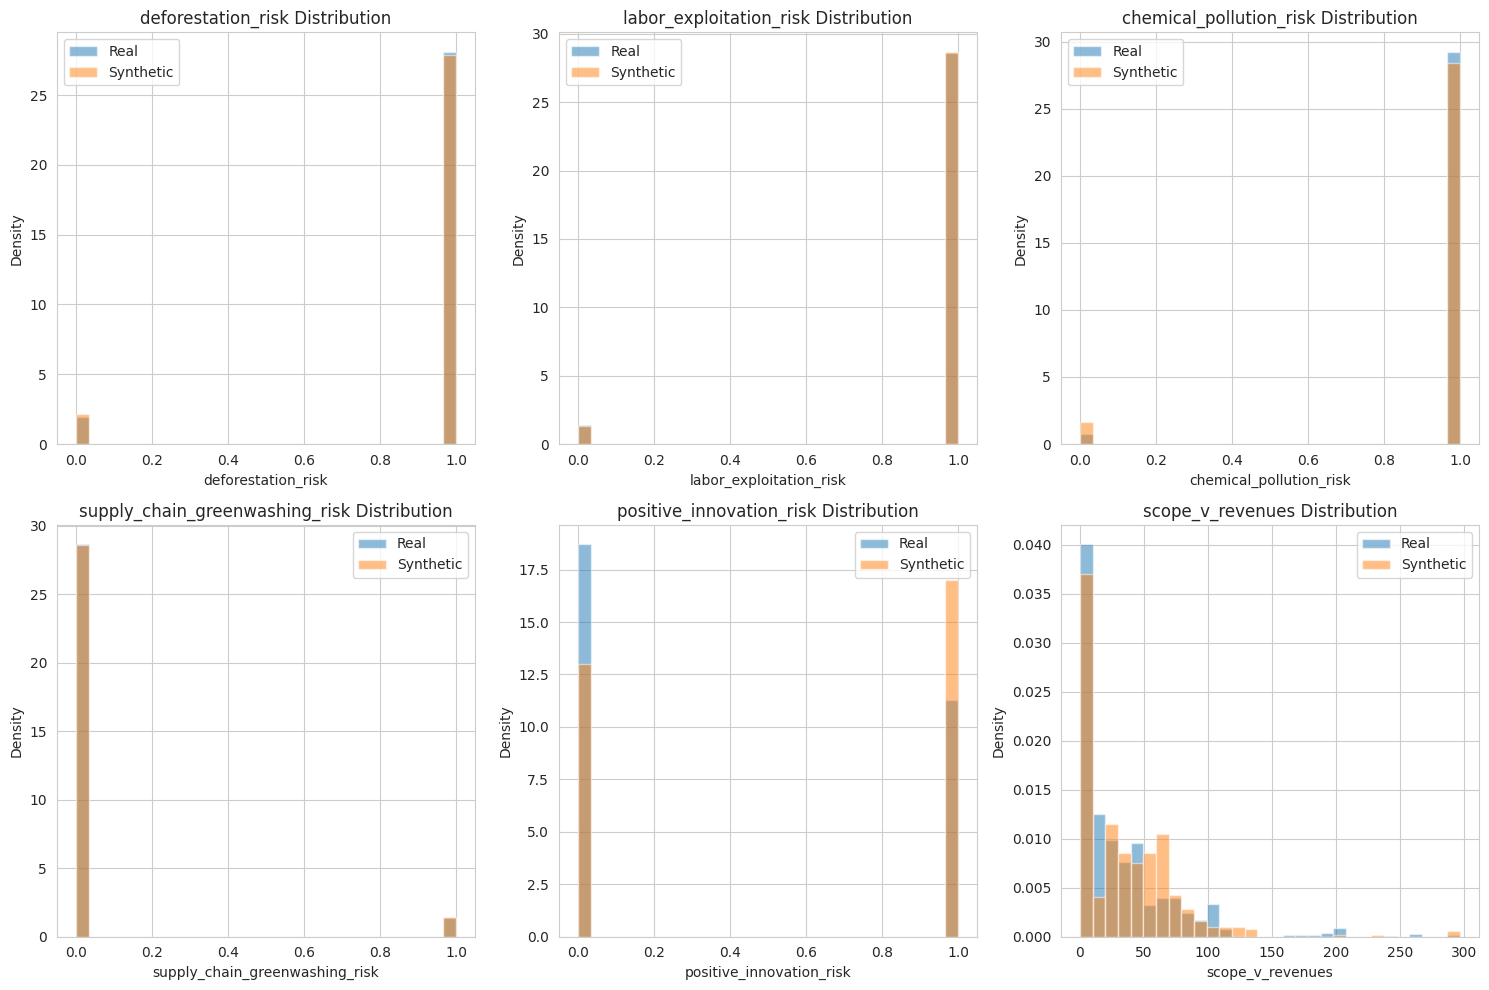

In [47]:
# Visualize distribution comparisons
evaluator.plot_distribution_comparison(
    real_data=df_clean,
    synthetic_data=synthetic_with_names,
    features=numerical_cols[:6]
)

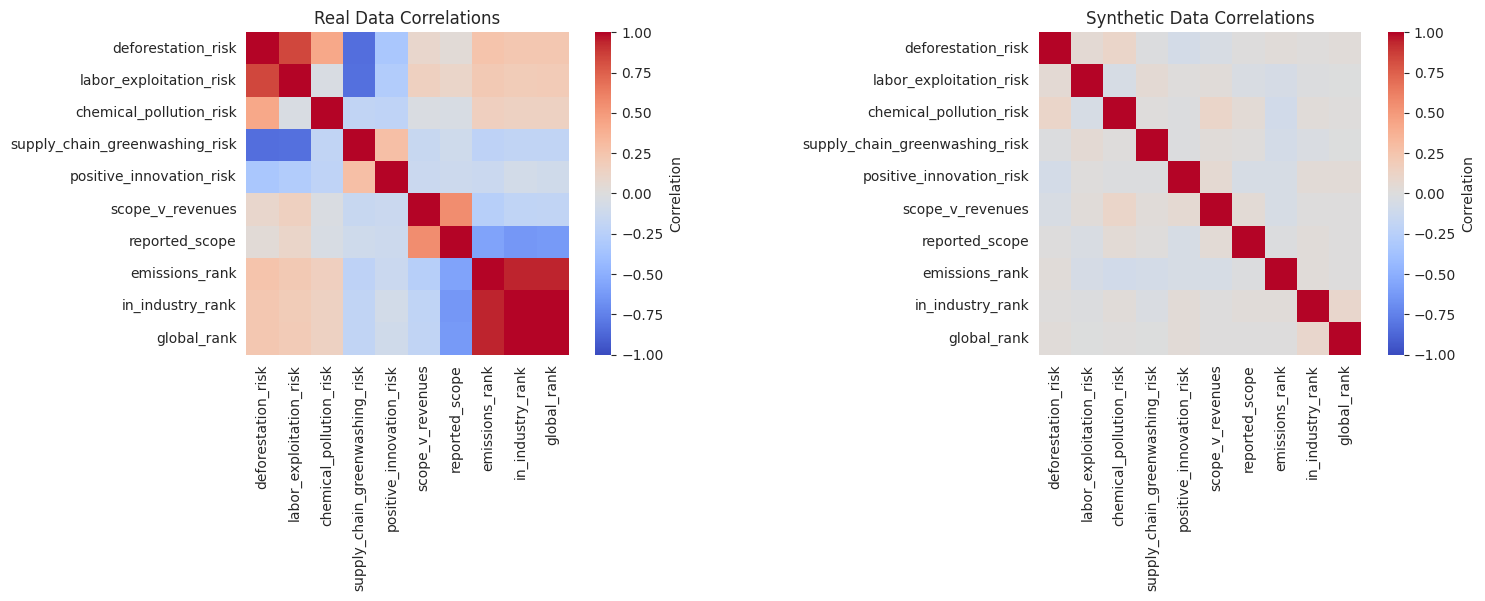

In [48]:
# Visualize correlation heatmaps
evaluator.plot_correlation_heatmaps(real_corr, synth_corr)

## 5.2 PCA Visualization

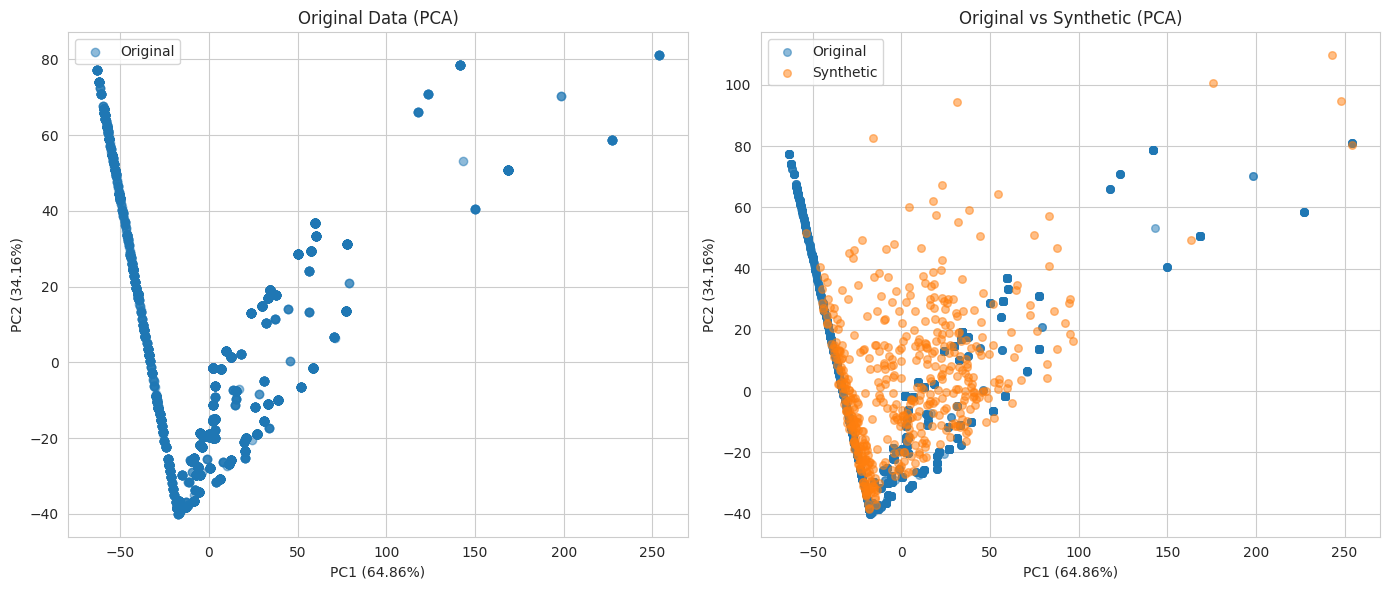

In [49]:
# PCA comparison
evaluator.plot_pca_comparison(
    original_data=df_clean,
    synthetic_data=synthetic_with_names,
    numerical_cols=numerical_cols
)

## 5.3 Clustering Comparison (Main Goal)

In [50]:
# Compare clustering: Original vs Augmented
clustering_comparison = evaluator.compare_clustering(
    original_data=df_clean,
    augmented_data=augmented_df,
    numerical_cols=numerical_cols
)


CLUSTERING COMPARISON: Original vs Augmented

--- ORIGINAL DATA ---

=== Hierarchical Clustering ===
Number of clusters: 5
Silhouette score: 0.4689 (higher is better)
Davies-Bouldin score: 0.7178 (lower is better)
Cluster sizes: {np.int64(0): np.int64(782), np.int64(1): np.int64(1512), np.int64(2): np.int64(550), np.int64(3): np.int64(78), np.int64(4): np.int64(683)}

--- AUGMENTED DATA (Original + Synthetic) ---

=== Hierarchical Clustering ===
Number of clusters: 5
Silhouette score: 0.4305 (higher is better)
Davies-Bouldin score: 0.7796 (lower is better)
Cluster sizes: {np.int64(0): np.int64(863), np.int64(1): np.int64(1143), np.int64(2): np.int64(1661), np.int64(3): np.int64(83), np.int64(4): np.int64(355)}

IMPROVEMENTS
Silhouette improvement: -0.0383
Davies-Bouldin improvement: -0.0617 (negative means worse)


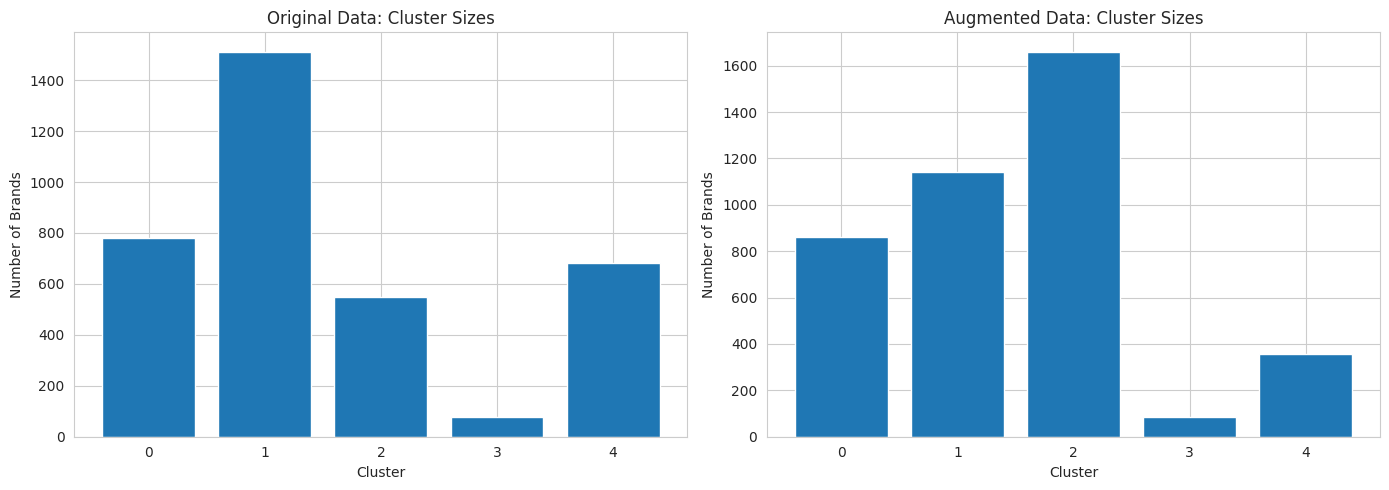

In [51]:
# Visualize cluster distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Original clustering
orig_dist = clustering_comparison['original']['cluster_distribution']
ax1.bar(orig_dist.keys(), orig_dist.values())
ax1.set_title('Original Data: Cluster Sizes')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Number of Brands')

# Augmented clustering
aug_dist = clustering_comparison['augmented']['cluster_distribution']
ax2.bar(aug_dist.keys(), aug_dist.values())
ax2.set_title('Augmented Data: Cluster Sizes')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Number of Brands')

plt.tight_layout()
plt.show()

## 5.4 Generate Final Report

In [52]:
# Generate and display report
report = evaluator.generate_report()
print(report)

# Save report
report_path = os.path.join(OUTPUT_DIR, 'evaluation_report.txt')
with open(report_path, 'w') as f:
    f.write(report)
print(f"\nReport saved to: {report_path}")

SYNTHETIC DATA EVALUATION REPORT

--- Distribution Similarity (KS Tests) ---
Passing features: 4/10 (40.0%)

--- Correlation Preservation ---
Mean absolute difference: 0.2730

--- Clustering Quality ---
Original silhouette: 0.4689
Augmented silhouette: 0.4305
Improvement: -0.0383


Report saved to: ../data/generated/evaluation_report.txt


---
# Summary & Conclusions

In [53]:
print("="*70)
print("SYNTHETIC BRAND GENERATION: FINAL SUMMARY")
print("="*70)
print(f"\n📊 Dataset Statistics:")
print(f"  Original brands: {len(df_clean)}")
print(f"  Synthetic brands generated: {len(synthetic_with_names)}")
print(f"  Augmented dataset total: {len(augmented_df)}")
print(f"  Augmentation ratio: {len(synthetic_with_names)/len(df_clean)*100:.1f}%")

print(f"\n🎯 Clustering Results:")
orig = clustering_comparison['original']
aug = clustering_comparison['augmented']
print(f"  Original - Clusters: {orig['n_clusters']}, Silhouette: {orig['silhouette_score']:.4f}")
print(f"  Augmented - Clusters: {aug['n_clusters']}, Silhouette: {aug['silhouette_score']:.4f}")
print(f"  Improvement: {clustering_comparison['silhouette_improvement']:+.4f}")

print(f"\n📁 Output Files:")
print(f"  Synthetic brands: {synthetic_path}")
print(f"  Augmented dataset: {augmented_path}")
print(f"  CTGAN model: {ctgan_model_path}")
print(f"  Name generator: {gpt2_output_dir}")
print(f"  Evaluation report: {report_path}")

print("\n✅ Pipeline completed successfully!")
print("="*70)

SYNTHETIC BRAND GENERATION: FINAL SUMMARY

📊 Dataset Statistics:
  Original brands: 3605
  Synthetic brands generated: 500
  Augmented dataset total: 4105
  Augmentation ratio: 13.9%

🎯 Clustering Results:
  Original - Clusters: 5, Silhouette: 0.4689
  Augmented - Clusters: 5, Silhouette: 0.4305
  Improvement: -0.0383

📁 Output Files:
  Synthetic brands: ../data/generated/synthetic_brands.csv
  Augmented dataset: ../data/generated/augmented_brands.csv
  CTGAN model: ../models/ctgan_brand_model.pkl
  Name generator: ../models/brand_name_generator
  Evaluation report: ../data/generated/evaluation_report.txt

✅ Pipeline completed successfully!


---
## Optional: Load Pre-trained Models

If you want to skip training and load previously saved models:

In [54]:
# Load CTGAN model
# ctgan = TabularBrandGAN()
# ctgan.load_model(ctgan_model_path)

# Load brand name generator
# name_generator = BrandNameGenerator()
# name_generator.load_model(gpt2_output_dir)